# ADA 2019 – Project Milestone 3
## Evolution of the Music Industry
### Team *Master Yada*:
Jan Waligorski, Jean-Baptiste Membrado, Thomas Petit-Jean, Alexandre Cionca

In [1]:
'''
FILL THE SHIT BELOW!!
'''

'\nFILL THE SHIT BELOW!!\n'

**Scope:**

**Datasets – [Discogs](https://www.discogs.com/search/?ev=em_rs):**
- Releases.xml (6.5GB zipped): each Row is a released song/album on a specific format, with specific specs. Because of its size (40Go), we did some processing on the ADA cluster and saved the smaller extracted DataFrame locally. To do some tests, we also extracted a smaller dataset (100Mo) named releases_small.xml.
- Masters.xml (197.7MB zipped): each Row is a Master, i.e. the support of various releases

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyspark

from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark import SparkContext

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import plot

import os

In [3]:
# Setting up PySpark
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.7.0 pyspark-shell'

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','6g'), # your
                                   ('spark.driver.maxResultSize', '4G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

## Data Loading

In [4]:
# Opening masters.xml as a Spark DataFrame
discogs_masters = spark.read.format("xml") \
                        .option("rowTag","master") \
                        .load("discogs_20191101_masters.xml.gz")

In [5]:
# Display schema
discogs_masters.printSchema()

root
 |-- _id: long (nullable = true)
 |-- artists: struct (nullable = true)
 |    |-- artist: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- anv: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- join: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- role: string (nullable = true)
 |    |    |    |-- tracks: string (nullable = true)
 |-- data_quality: string (nullable = true)
 |-- genres: struct (nullable = true)
 |    |-- genre: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- images: struct (nullable = true)
 |    |-- image: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _VALUE: string (nullable = true)
 |    |    |    |-- _height: long (nullable = true)
 |    |    |    |-- _type: string (nullable = true)
 |    |    |    |-- _uri: string (nullable = true)
 |    |  

In [6]:
discogs_masters.filter(discogs_masters.year == 0).count()

97800

In [7]:
# Number of masters
discogs_masters.count()

1587241

> As seen on the printed scheme above, the data require some filtering of the desired features as well as some data entries.

In [ ]:
## The following dataframes were generated on the full dataset thanks to the cluster
## DO NOT RUN this cell: it is just to show how the various files were obtained

r2 = spark.read.format("xml") \
    .option("rowTag","release") \
    .load("releases_small.xml")

## years.csv
# Number of release per year
release_count = r2.select(F.year(F.to_date(r2.released)).alias('year')) \
             .groupBy('year').agg(count("*").alias('numb_rel')).fillna(0)

## genres.csv
# Number of release per year and per genre
df_genres = r2.select(explode(r2.genres.genre).alias("genre"), \
                      F.year(F.to_date(r2.released)).alias('year')) \
              .groupBy('year','genre') \
              .agg(count("*").alias('numb_rel'))

## styles.csv
# Number of electronic release per year and per style (a style being a 'subgenre')
df_styles = r2.select(F.year(F.to_date(r2.released)).alias('year'), \
                     F.explode(r2.genres.genre).alias("genre"), \
                     'styles').filter(F.col('genre') == 'Electronic') \
                         .select('year',F.explode(r2.styles.style).alias('style')) \
                         .groupBy('year','style') \
                         .agg(count("*").alias('numb_rel')).fillna(0, subset = ['year'])

## master_release_format.json
# For each master : (number of / labels / format / year) of the corresponding releases 
dfMR = r2.na.drop(subset=["_id","master_id._VALUE","master_id._is_main_release","labels"])\
         .select(r2._id.alias('id'), \
                r2.master_id._VALUE.alias('master_id'), \
                r2.master_id._is_main_release.alias('is_main'), \
                r2.labels.label._name[0].alias('label'), \
                r2.formats.format._name[0].alias('format'), \
                F.year(F.to_date(r2.released)).alias('year')) \
         .groupBy("master_id").agg(collect_set("label").alias('labels'),
                                   count('id'),
                                   collect_set("format"),
                                   collect_list("year"))

### Pre-Processing

In [8]:
# Reducing the number of features since some of them seems pretty useless
# and to improve computation time as well.
selected_features = ['_id', 'artists', 'data_quality', 'genres', 'styles', 'title', 'year']

# A first filtering could be to use the "data_quality" feature. It describe if the entry has
# been "validated" by the Discogs administrators. Thus, we will only keep "Correct" entries.

# A second preprocessing step would be to remove all entries with missing years. Since our
# dataset is big enough, it is easier for us (and for later computations) to remove these rows
# instead of filling the missing values. Note that Masters with no publication years 

masters = discogs_masters.select(selected_features)\
                            .filter(discogs_masters.data_quality == "Correct")\
                            .filter(discogs_masters.year > 0)\
                            .dropna(subset = "year")

In [9]:
# Number of total elements after filtering
masters.count()

1485370

In [10]:
# Storing Master into Pandas
master_DF = masters.toPandas().rename(columns = {'_id':'master_id'})

master_DF.head()

,master_id,artists,data_quality,genres,styles,title,year
0,18500,"([(Samuel L, 212070, , Samuel L Session, , )],)",Correct,"([Electronic],)","([Techno],)",New Soil,2001
1,18512,"([(, 212070, , Samuel L Session, , )],)",Correct,"([Electronic],)","([Tribal, Techno],)",Psyche EP,2002
2,27800,"([(, 278, , Peshay, , )],)",Correct,"([Electronic],)","([Drum n Bass],)",Renegades Of Funk,2001
3,57416,"([(, 3225, , Vince Watson, , )],)",Correct,"([Electronic],)","([Techno],)",Tuff Trax #1 - Basic Functions,1996
4,57427,"([(, 3225, , Vince Watson, , )],)",Correct,"([Electronic],)","([Techno, Downtempo],)",The eMotion Sequence,2006


In [11]:
# Loading of music Label and Format (cd or vinyl) list for each master_id
# (previously computed on the cluster)
labels = pd.read_json('master_labels_format.json', lines = True)\
            .rename(columns = {'count(id)':'n_releases',
                               'collect_set(format)':'format'})\
            .set_index('master_id')

labels.head()

,labels,n_releases,format
master_id,,,
474,[Stateart],3,[Vinyl]
964,[Stuffrecords],2,[Vinyl]
1677,[Maurizio],10,"[File, Vinyl]"
1697,[Cronomi Records],3,[File]
1806,[E:Motion],2,[CD]


In [12]:
# Joining datasets together
master_full_DF = master_DF.join(labels, on = 'master_id', how = 'inner')\
                            .drop(columns = ['data_quality'])
master_full_DF.head()

,master_id,artists,genres,styles,title,year,labels,n_releases,format
0,18500,"([(Samuel L, 212070, , Samuel L Session, , )],)","([Electronic],)","([Techno],)",New Soil,2001,[SLS],3,"[CD, Vinyl]"
1,18512,"([(, 212070, , Samuel L Session, , )],)","([Electronic],)","([Tribal, Techno],)",Psyche EP,2002,[SLS],2,[Vinyl]
2,27800,"([(, 278, , Peshay, , )],)","([Electronic],)","([Drum n Bass],)",Renegades Of Funk,2001,[Renegade Recordings],2,[CD]
3,57416,"([(, 3225, , Vince Watson, , )],)","([Electronic],)","([Techno],)",Tuff Trax #1 - Basic Functions,1996,[Club Craft],2,[Vinyl]
4,57427,"([(, 3225, , Vince Watson, , )],)","([Electronic],)","([Techno, Downtempo],)",The eMotion Sequence,2006,[Delsin],2,"[CD, Vinyl]"


In [13]:
# Extracting Genres & Styles out of the RDD rows into lists of strings
master_full_DF.loc[:, 'genres'] = master_full_DF.genres.apply(lambda x: x.genre)

# Some master have "None" Style and thus, we must define a alternate function.
def get_style(row):
    if row is not None:
        return row.style
    else:
        return ['unknown']

master_full_DF.loc[:, 'styles'] = master_full_DF.styles.apply(get_style)

master_full_DF.head()

,master_id,artists,genres,styles,title,year,labels,n_releases,format
0,18500,"([(Samuel L, 212070, , Samuel L Session, , )],)",[Electronic],[Techno],New Soil,2001,[SLS],3,"[CD, Vinyl]"
1,18512,"([(, 212070, , Samuel L Session, , )],)",[Electronic],"[Tribal, Techno]",Psyche EP,2002,[SLS],2,[Vinyl]
2,27800,"([(, 278, , Peshay, , )],)",[Electronic],[Drum n Bass],Renegades Of Funk,2001,[Renegade Recordings],2,[CD]
3,57416,"([(, 3225, , Vince Watson, , )],)",[Electronic],[Techno],Tuff Trax #1 - Basic Functions,1996,[Club Craft],2,[Vinyl]
4,57427,"([(, 3225, , Vince Watson, , )],)",[Electronic],"[Techno, Downtempo]",The eMotion Sequence,2006,[Delsin],2,"[CD, Vinyl]"


## Master or Release
Albums on discogs are ordered as Master (unique) and Releases (different version of a Master).

In [14]:
'''
USE .csv TO SHOW NUMBER OF RELEASES!!
'''

'\nUSE .csv TO SHOW NUMBER OF RELEASES!!\n'

In [15]:
master_rel_per_year = master_full_DF[['year', 'n_releases']].groupby('year').n_releases

In [45]:
import plotly.graph_objects as go

x = master_rel_per_year.count().index.values

fig = make_subplots(rows=2, cols=1, shared_xaxes = True,
                    x_title = 'Year', y_title = 'Count', vertical_spacing=0.1,
                    subplot_titles=("Number of Releases & Masters",
                                    "Mean number of Releases per Master (with 99% CI)"))

for g, lab in zip([master_rel_per_year.sum(), master_rel_per_year.count()],
                    ['# releases', '# masters']):
    fig.add_trace(go.Scatter(
        x=g.index.values,
        y=g.values,
        mode='lines',
        name=lab,
    ), row=1, col=1)
    
ci = 2.756 * master_rel_per_year.std()/(np.sqrt(len(master_rel_per_year)))
ci[ci == np.nan] = 0

upper = master_rel_per_year.mean().values + ci
lower = master_rel_per_year.mean().values - ci

fig.add_trace(go.Scatter(
    x=x,
    y=upper,
    mode='lines',
    name='',
    line=dict(width=0, color='rgba(80, 20, 80, 0.3)')
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=master_rel_per_year.mean().values,
    mode='lines',
    name='Mean #Releases',
    fill='tonexty',
    fillcolor='rgba(80, 20, 80, 0.3)'
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=x,
    y=lower,
    mode='lines',
    name='99% CI',
    line=dict(width=0, color='rgba(80, 20, 80, 0.3)'),
    fill='tonexty',
    fillcolor='rgba(80, 20, 80, 0.3)'
), row=2, col=1)

fig.update_layout(
    title="Masters VS Releases",
    height = 600,
    showlegend=True,
)

plot(fig, filename='masterVSreleases.html')
fig.show()

'masterVSreleases.html'

> Number of Releases may be inaccurate in this plot. Indeed, if a release (re-edition for example) is out 5 years after the master year, it will still count for the **master year** (and not the actual release year). This will be improved by using the *Release* dataset.

On this graph, we can see the evolutions of the number of masters - thus albums - per year. Nota bene, we correlate the number of releases with the health of the music industry; as if it grows and generate money, it will reinvest that money into the making and marketing of new releases.

From the 50s, the post-World War II economic expansion had a huge impact on consumerism, especially in the U.S. Goods and services were created deliberately for young people as spending power skyrocketted. The access of music through the democratisation of vinyl created a huge expansion of the newborn music industry. We can hypothesize that the dip in the 70s comes respectively from the oil crash in 1973 and the energy crisis in 1979. These events led to a period of recession, affecting all the markets, including the music one. One could argue that the second dip in the 2000s was caused by the internet as music piracy exploded (the famous peer-to-peer website Nasper was launched in 1999) leading to a decline in CD sales, thus again affecting the industry. Surely, the financial crash of 2008 did not help. The huge peak in the recent years could be the development of many streaming platforms - as increasing internet data rates allowed continous streaming of media - democratizing even more various artists.

Notwithstanding this last point, we can distinguish a certain form of exhausation (i.e. if we compare this market with the demographic expansion) maybe caused by a saturation of various artists led by the streaming revolution.

## Genres & Styles
### Genres distribution over the years
Let's now have a look at the evolution of genre distribution over the years.

In [17]:
## Genres per year
exploded_genres = master_full_DF[['year', 'genres', 'labels',
                                  'format', 'n_releases']].explode('genres')

genres_DF = exploded_genres.groupby(['year', 'genres']).n_releases.count().reset_index()\
                            .rename(columns = {'n_releases':'#masters'})

In [18]:
all_genres = exploded_genres.genres.value_counts().reset_index()\
                            .rename(columns = {'index':'genres', 'genres':'#masters'})

In [48]:
fig = px.bar(all_genres, x='genres', y='#masters', title='Overall number of Masters per Genre')
plot(fig, filename='Overall_genres.html')
fig.show()

In [20]:
'''
SHOULD WE KEEP THE SHIT BELOW?!
'''

'\nSHOULD WE KEEP THE SHIT BELOW?!\n'

In [49]:
fig = px.area(genres_DF, x="year", y="#masters", color='genres')
plot(fig, filename='Genres_perYears_UNORM.html')
fig.show()

In [50]:
import plotly.graph_objects as go

x = genres_DF.year.sort_values().unique()
fig = go.Figure(layout_title_text='Genre Distribution over the years')

sorted_genres = genres_DF.groupby('genres')['#masters'].sum().sort_values(ascending = False)

all_shown, top10, top5 = [], [], []

for idx, g in enumerate(genres_DF.genres.unique()):
        
    all_shown.append(True)
    top10.append(g in sorted_genres[:10])
    top5.append(g in sorted_genres[:5])
            
    
    data = genres_DF[genres_DF.genres == g].sort_values('year')
    
    fig.add_trace(go.Scatter(
        x = data.year,
        y = data['#masters'],
        mode='lines',
        name=g,
        stackgroup='one',
        hovertemplate='Year: %{x}<br> Percentage: %{y:2.2f}%',
        groupnorm='percent' # sets the normalization for the sum of the stackgroup
    ))

fig.update_layout(
    title="Discogs Genre Distribution",
    height = 600,
    xaxis_title="Year",
    yaxis_title="Percentage of Master",
    showlegend=True,
    xaxis=go.layout.XAxis(
        rangeslider=dict(
            visible=True
        ),
        type="linear",
        range=[1940, 2017]
    ),
    yaxis=dict(
        type='linear',
        range=[1, 105],
        ticksuffix='%'),
    updatemenus=[
        go.layout.Updatemenu(
            type="buttons",
            direction="right",
            active=0,
            x=0.3,
            y=1.12,
            buttons=list([
                dict(label="All Genres",
                     method="update",
                     args=[{"visible": all_shown},
                           {"title": "Discogs Genre Distribution",
                            "annotations": [],
                            "range":"auto"}]),
                dict(label="Top 5",
                     method="update",
                     args=[{"visible": top5},
                           {"title": "Discogs Genre Distribution (Top 5)",
                            "annotations": []}]),
                dict(label="Top 10",
                     method="update",
                     args=[{"visible": top10},
                           {"title": "Discogs Genre Distribution (Top 10)",
                            "annotations": []}]),
            ]),
        )
    ])


plot(fig, filename='Genres_perYears_NORM.html')
fig.show()

Here we can see the evolution of genres throughout the years. Some genres appeared and exploded like Electronic music in the 80s caused by the creation of samplers and drum machines. Some nearly dissapeared like blues.

From this graph, we can see that recently the most dominant genres are Rock and Electronic but this doesn't correspond to the recent charts for Rock. Hiphop is in fact more relevant nowadays than rock in terms of streams/sales. We could argue that as the audience of Hiphop artists mainly consume this type of music on streaming platforms like Apple music, Spotify, Youtube, etc..., they make, on one hand less albums and more singles, and on the other hand simply do not release their music physically and only digitally, following the trends.

As Discogs is a library mostly composed of physical releases (CD, Vinyl, casette, ...), naturally the genres that release the most physically are over-represented on our graph.

### Styles are more than just detailed genres (or at least there are more of them)

In [23]:
genrestyles = master_full_DF.loc[:,['year', 'genres', 'styles']]
genrestyles['period'] = ''

for periods in [0, 1960, 1980, 2000]:
    genrestyles.loc[genrestyles.year >= periods, 'period'] = periods
gs_explode = genrestyles.explode('genres')
gs_explode.head()

,year,genres,styles,period
0,2001,Electronic,[Techno],2000
1,2002,Electronic,"[Tribal, Techno]",2000
2,2001,Electronic,[Drum n Bass],2000
3,1996,Electronic,[Techno],1980
4,2006,Electronic,"[Techno, Downtempo]",2000


In [24]:
def top_values(x, n = 20):
    return x.value_counts().head(n)

In [25]:
gs_periods = gs_explode.explode('styles').groupby(['period','genres']).styles
gs_periods = gs_periods.apply(top_values).reset_index()
# Not considering unknown or unspecified styles
gs_periods = gs_periods.loc[gs_periods.level_2 != 'unknown']
gs_periods

,period,genres,level_2,styles
0,0,Blues,Rhythm & Blues,2725
2,0,Blues,Rock & Roll,626
3,0,Blues,Vocal,589
4,0,Blues,Doo Wop,423
5,0,Blues,Jump Blues,372
...,...,...,...,...
1164,2000,Stage & Screen,Easy Listening,744
1165,2000,Stage & Screen,Hindustani,730
1166,2000,Stage & Screen,Downtempo,724
1167,2000,Stage & Screen,Electro,547


In [26]:
# Storing level 0 (periods) in a list
per = gs_periods.groupby('period').styles.sum()
gs_ids = per.index.tolist()
gs_labels = ["up to 1960", "1960-1980", "1980-2000", "2000-Now"]
gs_values = per.tolist()
gs_parents = ['' for _ in gs_values]

# Storing level 1 (genres) in the same list
GB_per_genres = gs_periods.groupby(['period', 'genres']).styles.sum().reset_index()

gs_ids += (GB_per_genres.period.astype(str)+' - '+GB_per_genres.genres).tolist()
gs_labels += GB_per_genres.genres.tolist()
gs_values += GB_per_genres.styles.tolist()
gs_parents += GB_per_genres.period.tolist()

# Storing level 2 (styles) in the same list
gs_ids += (gs_periods.period.astype(str)+' - '+gs_periods.genres+' - '+gs_periods.level_2).tolist()
gs_labels += gs_periods.level_2.tolist()
gs_values += gs_periods.styles.tolist()
gs_parents += (gs_periods.period.astype(str)+' - '+gs_periods.genres).tolist()

In [51]:
fig = go.Figure(go.Sunburst(
    ids=gs_ids,
    labels=gs_labels,
    parents=gs_parents,
    values=gs_values,
    branchvalues="total",
), layout_title_text = 'Top 20 Styles for each Genre')
fig.update_layout(margin = dict(t=50, l=0, r=0, b=0))

plot(fig, filename='Genres_Styles_Sunburst.html')

fig.show()

### Labels

In [28]:
# Storing the number of unique label per year
label_per_year = exploded_genres.groupby('year').agg({'labels':'nunique'})

# Storing the number of unique label per genre
label_per_genre = exploded_genres.groupby('genres').agg({'labels':'nunique', 
                                                        'n_releases':'sum'})\
                                    .sort_values(by = 'labels', ascending = False)

label_per_genre

,labels,n_releases
genres,,
Rock,219404,2347073
Electronic,162519,1616961
Pop,87323,1071904
"Folk, World, & Country",50471,443900
Funk / Soul,45485,538592
Jazz,43661,493667
Hip Hop,33854,303504
Classical,20562,240402
Latin,18604,148560


In [29]:
'''
MAKE THE MOFO BELOW AS INTERACTIV'N SWAGGEY AS POSSIBRUH!!
'''

"\nMAKE THE MOFO BELOW AS INTERACTIV'N SWAGGEY AS POSSIBRUH!!\n"

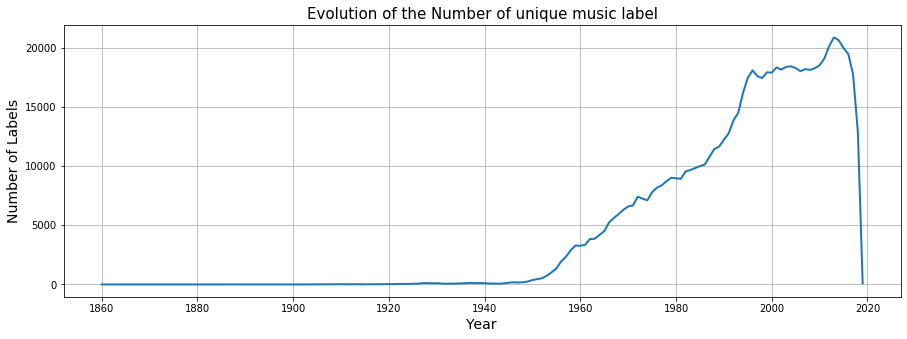

In [30]:
fig, ax = plt.subplots(figsize = (15, 5))
plt.title('Evolution of the Number of unique music label',
          fontsize = 15)

plt.plot(label_per_year.index.values, label_per_year.values, linewidth = 2)

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Number of Labels', fontsize = 14)

plt.grid()

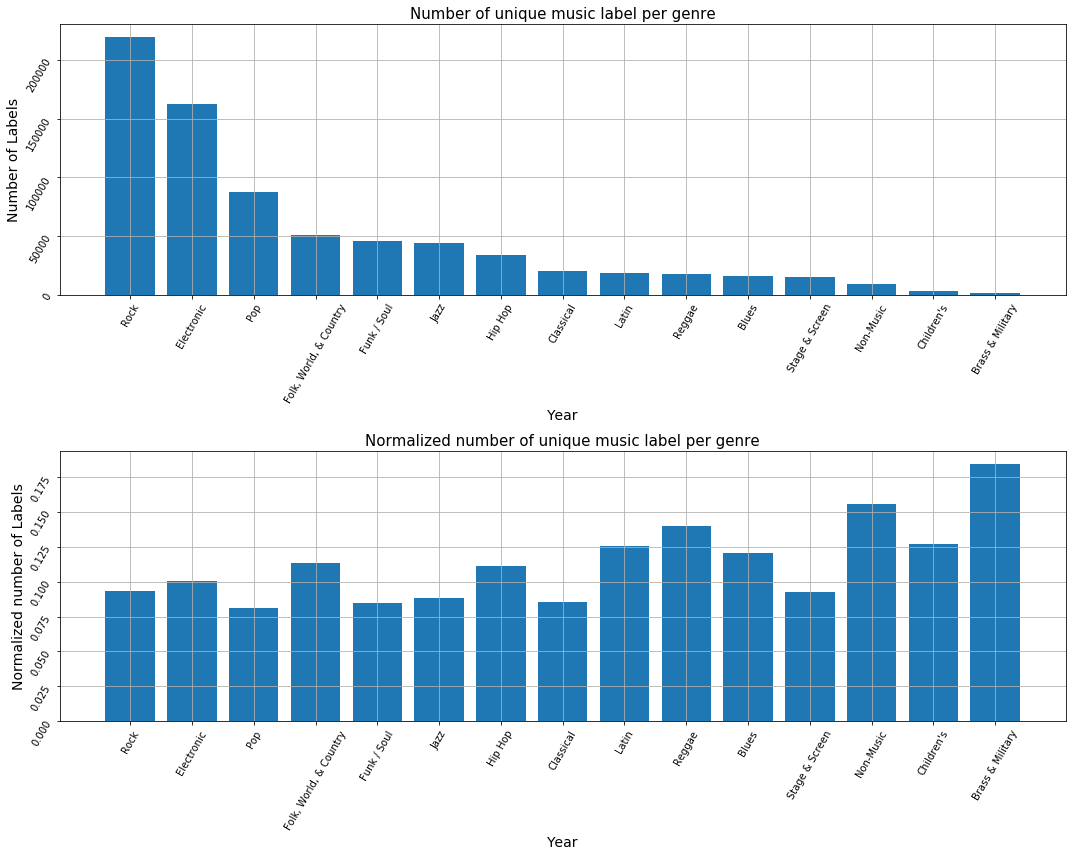

In [31]:
fig, ax = plt.subplots(figsize = (15, 12))

ax = plt.subplot(2,1,1)
plt.title('Number of unique music label per genre',
          fontsize = 15)

plt.bar(label_per_genre.index.values, label_per_genre.labels.values, linewidth = 2)

ax.tick_params(labelrotation = 60)

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Number of Labels', fontsize = 14)

plt.grid()

ax = plt.subplot(2,1,2)
plt.title('Normalized number of unique music label per genre',
          fontsize = 15)

plt.bar(label_per_genre.index.values,
        label_per_genre.labels.values/label_per_genre.n_releases.values, linewidth = 2)

ax.tick_params(labelrotation = 60)

plt.xlabel('Year', fontsize = 14)
plt.ylabel('Normalized number of Labels', fontsize = 14)

plt.grid()
plt.tight_layout()

> Here, the bigger the barplot, the better the diversity of labels per genre. We can comment that :
- Pop, the genre with the most capitalization per artist, show less label diversity maybe because all the songs come out on big labels that are not numerous.
- Niche genres like Jazz, Funk/Soul show less label diversity as they have less consumers, thus less market shares so not many labels can successfully coexist and survive.

In [32]:
label_DF = exploded_genres.groupby(['year', 'genres']).labels.sum().reset_index()

label_DF.loc[:,'unique_labels'] = label_DF.labels.apply(lambda x: len(set(x)))
label_DF

,year,genres,labels,unique_labels
0,1860,Children's,[Not On Label (Édouard-Léon Scott De Martinvil...,2
1,1896,Jazz,"[E. Berliner's Gramophone, Victor, Zonophone R...",3
2,1896,Pop,"[Columbia, Not On Label]",2
3,1898,Jazz,[Kansas City Talking Machine Co.],1
4,1898,Non-Music,"[Indestructible Record, Columbia]",2
...,...,...,...,...
1419,2019,Non-Music,"[Psych.KG, American Damage]",2
1420,2019,Pop,"[Jezus Factory Records, Columbia, Not On Label...",16
1421,2019,Reggae,"[Paris DJs, Pressure Sounds, Smokecloud Records]",3
1422,2019,Rock,"[H42 Records, Fissile, Not On Label, Schoolkid...",67


In [59]:
lab_exp = label_DF.explode('labels')
top10_label_years = lab_exp.labels.value_counts()[1:11]
top10_label_years

Columbia           48757
Polydor            31111
EMI                31016
RCA                28169
CBS                27371
RCA Victor         24571
Epic               22577
Capitol Records    22118
Decca              21685
Philips            21297
Name: labels, dtype: int64

In [60]:
lab_exp = lab_exp[[lab in top10_label_years.index.tolist() for lab in lab_exp.labels]]
lab_exp

,year,genres,labels,unique_labels
2,1896,Pop,Columbia,2
4,1898,Non-Music,Columbia,2
8,1902,Jazz,Columbia,2
10,1902,Stage & Screen,Columbia,2
11,1903,"Folk, World, & Country",Columbia,2
...,...,...,...,...
1410,2018,Stage & Screen,Capitol Records,279
1410,2018,Stage & Screen,Capitol Records,279
1412,2019,Classical,Decca,6
1415,2019,Funk / Soul,Columbia,8


In [67]:
lab_exp['period'] = 1940
lab_exp

,year,genres,labels,unique_labels,period
2,1896,Pop,Columbia,2,1940
4,1898,Non-Music,Columbia,2,1940
8,1902,Jazz,Columbia,2,1940
10,1902,Stage & Screen,Columbia,2,1940
11,1903,"Folk, World, & Country",Columbia,2,1940
...,...,...,...,...,...
1410,2018,Stage & Screen,Capitol Records,279,1940
1410,2018,Stage & Screen,Capitol Records,279,1940
1412,2019,Classical,Decca,6,1940
1415,2019,Funk / Soul,Columbia,8,1940


In [68]:
for periods in range(1950, 2020, 10):
    lab_exp.loc[lab_exp.year >= periods, 'period'] = periods
    
lab_exp

,year,genres,labels,unique_labels,period
2,1896,Pop,Columbia,2,1940
4,1898,Non-Music,Columbia,2,1940
8,1902,Jazz,Columbia,2,1940
10,1902,Stage & Screen,Columbia,2,1940
11,1903,"Folk, World, & Country",Columbia,2,1940
...,...,...,...,...,...
1410,2018,Stage & Screen,Capitol Records,279,2010
1410,2018,Stage & Screen,Capitol Records,279,2010
1412,2019,Classical,Decca,6,2010
1415,2019,Funk / Soul,Columbia,8,2010


In [69]:
top10_labels_years = lab_exp.groupby(['year', 'labels']).count().reset_index()
top10_labels_years

,year,labels,genres,unique_labels,period
0,1896,Columbia,1,1,1
1,1898,Columbia,1,1,1
2,1902,Columbia,2,2,2
3,1903,Columbia,1,1,1
4,1904,Columbia,2,2,2
...,...,...,...,...,...
843,2018,Polydor,112,112,112
844,2018,RCA,87,87,87
845,2018,RCA Victor,5,5,5
846,2019,Columbia,2,2,2


In [53]:
import plotly.graph_objects as go

x = top10_labels_years.year.sort_values().unique()
fig = go.Figure()

sorted_genres = top10_labels_years.groupby('labels').genres.sum().sort_values(ascending = False)

for idx, l in enumerate(top10_labels_years.labels.unique()):
    
    data = top10_labels_years[top10_labels_years.labels == l].sort_values('year')
    
    fig.add_trace(go.Scatter(
        x = data.year,
        y = data.genres,
        mode='lines',
        name=l,
        stackgroup='one',
        hovertemplate='Year: %{x}<br> #labels: %{y:2.2f}%',
        groupnorm='percent' # sets the normalization for the sum of the stackgroup
    ))

fig.update_layout(
    title="Top10 Label Share (based on masters)",
    height = 600,
    xaxis_title="Year",
    yaxis_title="Percentage of Master",
    showlegend=True,
    xaxis=go.layout.XAxis(
        rangeslider=dict(
            visible=True
        ),
        type="linear",
        range=[1950, 2017]
    ),
)

plot(fig, filename='Labels_top10_perYears.html')

fig.show()

In [70]:
top10_labels_genres = lab_exp.groupby(['period', 'genres', 'labels']).count().reset_index()
top10_labels_genres

,period,genres,labels,year,unique_labels
0,1940,Blues,Capitol Records,25,25
1,1940,Blues,Columbia,78,78
2,1940,Blues,Decca,68,68
3,1940,Blues,Philips,1,1
4,1940,Blues,Polydor,3,3
...,...,...,...,...,...
1024,2010,Stage & Screen,EMI,21,21
1025,2010,Stage & Screen,Epic,8,8
1026,2010,Stage & Screen,Polydor,25,25
1027,2010,Stage & Screen,RCA,15,15


In [71]:
import plotly.graph_objects as go

x = top10_labels_genres.labels.sort_values().unique()

fig = go.Figure()

sorted_genres = top10_labels_genres.groupby('labels').genres.sum().sort_values(ascending = False)

for idx, g in enumerate(top10_labels_genres.genres.unique()):
    
    data = top10_labels_genres[top10_labels_genres.genres == g]
    
    fig.add_trace(go.Bar(x=x, y = data.year, name=g, hovertemplate="%{y} Masters"))

fig.update_layout(
    barmode = 'stack',
    title="Top10 Label Share (based on masters)",
    xaxis={'categoryorder':'category ascending'},
    height = 600,
    xaxis_title="Year",
    yaxis_title="Percentage of Master",
    showlegend=True,
)

plot(fig, filename='Labels_top10_Share.html')

fig.show()

In [41]:
'''
ADD BUTTONS TO CHOOSE TIME PERIOD! [up to 1960, 1960-1980, 1980-2000, 2000-now]
–> Much clearer if not overall data
'''

'\nADD BUTTONS TO CHOOSE TIME PERIOD! [up to 1960, 1960-1980, 1980-2000, 2000-now]\n–> Much clearer if not overall data\n'

The evolution of label per genre doesn't show any particularly stricking informations. Nevertheless, we can highlight that the number of label for all genres reached a plateau around 1995 and that *Rock* appears to be the only genre with an increasing number of labels during this period. This could be explained by a "return" of the Rock popularity following the rise of the Electronic (early 1990's).

## Music support
As new technologies redefined the way people consume music, we will have a look at the evolution of music support and formats. To have a relevant representation of music format distribution over the years, we will use data from the *Releases* dataset that has been cleaned and saved after computations on the cluster.

In [42]:
## Use the format data generated on the cluster
format_df = pd.read_csv('formats.csv',header=None,
                        names = ['year', 'format','numb_rel']).sort_values(by=['format','year'])
format_df_clean = format_df[format_df.year > 0]
format_df_clean

,year,format,numb_rel
300,2005,12,1
1268,1959,4-Track Cartridge,1
635,1962,4-Track Cartridge,6
670,1963,4-Track Cartridge,4
437,1964,4-Track Cartridge,9
...,...,...,...
152,2017,Vinyl,64500
1329,2018,Vinyl,60262
816,2019,Vinyl,271
1226,2015,Wire Recording,1


In [55]:
import plotly.graph_objects as go

x = format_df_clean.year.sort_values().unique()
fig = go.Figure(layout_title_text='Discogs Format Distribution')

sorted_formats = format_df_clean.groupby('format').numb_rel.sum().sort_values(ascending = False)

all_shown, top10, top5 = [], [], []

for idx, f in enumerate(format_df_clean.format.unique()):
        
    all_shown.append(True)
    top10.append(f in sorted_formats[:10])
    top5.append(f in sorted_formats[:5])
            
    
    data = format_df_clean[format_df_clean.format == f].sort_values('year')
    
    fig.add_trace(go.Scatter(
        x = data.year,
        y = data.numb_rel,
        mode='lines',
        #line=dict(width=0.5, color=col),
        name=f,
        stackgroup='one',
        hovertemplate='Year: %{x}<br> Percentage: %{y:2.2f}%',
        groupnorm='percent' # sets the normalization for the sum of the stackgroup
    ))

fig.update_layout(
    height = 600,
    xaxis_title="Year",
    yaxis_title="Percentage of Releases",
    showlegend=True,
    xaxis=go.layout.XAxis(
        rangeslider=dict(
            visible=True
        ),
        type="linear",
        range=[1940, 2019]
    ),
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'),
    updatemenus=[
        go.layout.Updatemenu(
            type="buttons",
            direction="right",
            active=0,
            x=0.3,
            y=1.12,
            buttons=list([
                dict(label="All",
                     method="update",
                     args=[{"visible": all_shown},
                           {"title": "Discogs Format Distribution",
                            "annotations": [],
                            "range":"auto"}]),
                dict(label="Top 5",
                     method="update",
                     args=[{"visible": top5},
                           {"title": "Discogs Format Distribution (Top 5)",
                            "annotations": []}]),
                dict(label="Top 10",
                     method="update",
                     args=[{"visible": top10},
                           {"title": "Discogs Format Distribution (Top 10)",
                            "annotations": []}]),
            ]),
        )
    ])


plot(fig, filename='Support_perYears.html')

fig.show()

On this graph, we can see on which format music is released. From the colossal dominance of Vinyl to the technological revolution leading to CD, the way we consume music is everchanging. Note that this graph does not only represent the format on which labels released their music on the actual year of the release, but it also includes all the reedition that were made a posteriori (CD was invented in 1982, but we see this format before on the graph). Thus, a Master from the 1960's that was re-edited and ported to CD's later in the 1985's will appear as a CD release from the 1960's (year of the Master).

Also, as streaming is the main way we consume music nowadays, "File" should be the main format but it is not the case here. From this and our other graphs, we suspect the File database is not complete on Discogs.